In [13]:
import os
import itertools 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

from multiprocessing import Pool
import gc

In [14]:
n_cores = 24
seed = 42
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'

Load the data:

In [15]:
X_train_val = pd.read_csv(os.path.join(data_path, 'interim', 'X_train_val.csv'), index_col = 0)
y_train_val = pd.read_csv(os.path.join(data_path, 'interim', 'y_train_val.csv'), index_col = 0)

X_test = pd.read_csv(os.path.join(data_path, 'interim', 'X_test.csv'), index_col = 0)
y_test = pd.read_csv(os.path.join(data_path, 'interim', 'y_test.csv'), index_col = 0)

317 of 32144 features were selected by elastic net


''

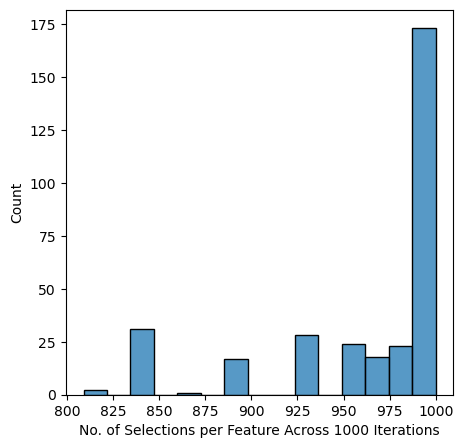

In [16]:
selected_features = pd.read_csv(os.path.join(data_path, 'interim', 'selected_features.csv'), index_col = 0)
print('{} of {} features were selected by elastic net'.format(selected_features.shape[0], X_train_val.shape[1]))

fig, ax = plt.subplots(figsize = (5,5))
sns.histplot(selected_features['V1'], ax = ax)
ax.set_xlabel('No. of Selections per Feature Across 1000 Iterations')
;


Format and filter for selected features:

In [74]:
selected_feature_index = selected_features.index.tolist()
selected_feature_index = ['-'.join(i.split('.')) for i in selected_feature_index] # formatting R --> python

X_train_val.columns = ['-'.join(col.split('.')) for col in X_train_val.columns]
X_test.columns = ['-'.join(col.split('.')) for col in X_test.columns]

X_train_val = X_train_val.loc[:, selected_feature_index]
X_test = X_test.loc[:, selected_feature_index]

X_train_val.to_csv(os.path.join(data_path, 'interim', 'X_train_val_selected.csv'))
X_test.to_csv(os.path.join(data_path, 'interim', 'X_test_selected.csv'))

Set the hyperparameters to iterate through

In [48]:
n_estimators_all = range(100, 1001, 250)
max_features_all = ['sqrt', 'log2', 0.5, 0.75, 1]
max_samples_all = [0.25, 0.5, 0.75, None]
max_depth = [None, 10, 25, 50, 100, 200]
min_samples_split_all = [2, 5, 10]
min_samples_leaf_all = [1, 2, 4]


combs = list(itertools.product(n_estimators_all, max_features_all,max_samples_all, 
                               max_depth, min_samples_split_all, min_samples_leaf_all))

The train/validation represents 80% of the total data. We will use 10-fold cross validation on this subset for hyperparameter tuning (72% training - 8% validation of the total data):

In [67]:
def par_hyperparam(hyperparams, kf, X_train_val, y_train_val):
    
    n_estimators, max_features, max_samples, max_depth, min_samples_split, min_samples_leaf = hyperparams
    k_mses = []
    for k, (train_index, test_index) in enumerate(kf.split(X_train_val, y_train_val)):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
        y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]

        model = RandomForestRegressor(n_estimators = n_estimators,
                                    max_features = max_features,
                                    max_samples = max_samples,
                                    bootstrap = True,
                                    max_depth = max_depth,
                                    min_samples_split = min_samples_split,
                                    min_samples_leaf = min_samples_leaf,
                                    n_jobs = 1,
                                    random_state = seed)

        model = model.fit(X_train, y_train.values.reshape(-1))
        y_pred = model.predict(X_val)
        y_val_values = y_val.values.reshape(-1)

        k_mses.append(mean_squared_error(y_val_values, y_pred))
    return k_mses

In [ ]:
# #initialize dataframe to store hyperparameters and metrics in:
kf = KFold(n_splits = 10, shuffle = True, random_state=seed)

# best_mse_val = -np.inf
# best_pearson_val = 0
# best_spearman_val = 0
# best_mse_params = [0, 0, 0]
# best_mse_models = None

hyperparam_names = ['n_estimators', 'max_features', 'max_samples', 'max_depth',  'min_samples_split', 
                'min_samples_leaf']

# bestmodels = pd.DataFrame(index=range(10), columns=['models'])

if n_cores <= 1: 
    values_index = hyperparam_names +  ['k', 'mse']#, 'pearson', 'spearman']
    res = pd.DataFrame(columns = values_index)
    for hyperparams in tqdm(combs):
#         k_mses = []
#         k_pearson = []
#         k_spearman = []
#         k_models = []

        n_estimators, max_features, max_samples, max_depth, min_samples_split, min_samples_leaf = hyperparams
        for k, (train_index, test_index) in enumerate(kf.split(X_train_val, y_train_val)):
            X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
            y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]

            model = RandomForestRegressor(n_estimators = n_estimators,
                                        max_features = max_features,
                                        max_samples = max_samples,
                                        bootstrap = True,
                                        max_depth = max_depth,
                                        min_samples_split = min_samples_split,
                                        min_samples_leaf = min_samples_leaf,
                                        n_jobs = n_cores,
                                        random_state = seed)

            model = model.fit(X_train, y_train.values.reshape(-1))
            y_pred = model.predict(X_val)
            y_val_values = y_val.values.reshape(-1)
            
            k_mse = mean_squared_error(y_val_values, y_pred)
#             k_pearson = stats.pearsonr(y_val_values, y_pred).statistic
#             k_spearman = stats.spearmanr(y_val_values, y_pred).statistic
            
            res.loc[res.shape[0],:] = list(hyperparams) + [k, k_mse]#, k_pearson, k_spearman]

#           k_mses.append(msq(y_val_values, y_pred))
#           k_pearson.append(pearson(y_val_values, y_pred))
#           k_spearman.append(spearman(y_val_values, y_pred))
#           k_models.append(model)

#         curr_mse = np.mean(k_mses)
#         curr_pearson = np.mean(k_pearson)
#         curr_spearman = np.mean(k_spearman)

#         if curr_mse > best_mse_val:
#           best_mse_val = curr_mse
#           best_pearson_val = curr_pearson
#           best_spearman_val = curr_spearman
#           best_mse_params = hyperparams
#           best_mse_models = k_models
        # do your standard k-fold CV assessment on each of the hyperparameter combinations as before and get metrics
else:
    pool = Pool(processes = min(n_cores, len(combs)))
    par_inputs = [(hyperparams, kf, X_train_val, y_train_val) for hyperparams in combs]
    par_res = pool.starmap(par_hyperparam, par_inputs)
    del par_inputs
    pool.close()
    pool.join()
    gc.collect()
    
    # format results
    rows = []
    for k, (hyperparams, res) in enumerate(zip(combs, par_res)):
        for value in res:
            rows.append({**{hn: hp for hn, hp in zip(hyperparam_names, hyperparams)}, "k": k, "mse": value})
    res = pd.DataFrame(rows)
    
# # # store results in a dataframe:
# res.iloc[0, :] = list(best_mse_params) + [best_mse_val, best_pearson_val, best_spearman_val]
# for i in range(10):
#   bestmodels.iloc[i, 0] = best_mse_models[i]
# save res as a csv
res.to_csv(os.path.join(data_path, 'interim', 'hyperparams.csv'))
# bestmodels.to_csv(os.path.join(data_path, 'bestmodels.csv'))

